https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899

# Modified Naive Bayes scores 0.899 LB - Santander
In this kernel we demonstrate that unconstrained Naive Bayes can score 0.899 LB. 

I call it "unconstrained" because it doesn't assume that each variable has a Gaussian distribution like typical Naive Bayes. Instead we allow for arbitrary distributions and we plot these distributions below. 

I called it "modified" because we don't reverse the conditional probabilities.

This kernel is useful because 

(1) it shows that an accurate score can be achieved using a simple model that assumes the variables are independent. And (2) this kernel displays interesting EDA which provides insights about the data.
  
# Load Data

In [1]:
import numpy as np, pandas as pd
train = pd.read_csv('../input/train.csv')
train0 = train[ train['target']==0 ].copy()
train1 = train[ train['target']==1 ].copy()
train.sample(5)

ID_code  target    var_0   ...     var_197  var_198  var_199
194844  train_194844       0  11.5100   ...      8.4787  17.7306  -6.9388
133016  train_133016       0  13.6502   ...      8.5060  16.9805  11.8371
56108    train_56108       0  14.8330   ...     10.5997  20.7202  -8.3218
49531    train_49531       0  12.9377   ...      8.2977  10.2940 -22.9666
101250  train_101250       0   5.9640   ...      8.5819  22.2410 -19.6145

[5 rows x 202 columns]

In [4]:
train.ID_code.nunique()

200000

In [2]:
train.shape

(200000, 202)

In [3]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

# Statistical Functions
Below are functions to calcuate various statistical things.

In [5]:
# CALCULATE MEANS AND STANDARD DEVIATIONS
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(train['var_'+str(i)])
    m[i] = np.mean(train['var_'+str(i)])
    
# CALCULATE PROB(TARGET=1 | X)
def getp(i,x):
    """
    计算 位于区间 x-s[i]/c < train1[var_i] < x+s[i]/c，的train1的样本数的概率(train1的样本数/位于该区间的样本总数)
    :i: var_i
    """
    c = 3 #smoothing factor
    # x-s[i]/c < train1[var_i] < x+s[i]/c
    a = len( train1[ (train1['var_'+str(i)]>x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)]>x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    if a+b<500: return 0.1 #smoothing factor 如果位于这个区间的总样本数<500，则返回0.1
    # RETURN PROBABILITY
    return a / (a+b)
    # ALTERNATIVELY RETURN ODDS
    # return a / b
    
# SMOOTH A DISCRETE FUNCTION
def smooth(x,st=1):
    for j in range(st):
        x2 = np.ones(len(x)) * 0.1
        for i in range(len(x)-2):
            x2[i+1] = 0.25*x[i]+0.5*x[i+1]+0.25*x[i+2]
        x = x2.copy()
    return x  # [0.1, x2[1], x2[2], ..., x2[len(x)-2], 0.1]

# Display Target Density and Target Probability
Below are two plots for each of the 200 variables. 
* The first is the density of `target=1` versus `target=0`. 
* The second gives the probability that `target=1` given different values for `var_k`.

Showing vars 0 to 7 ...


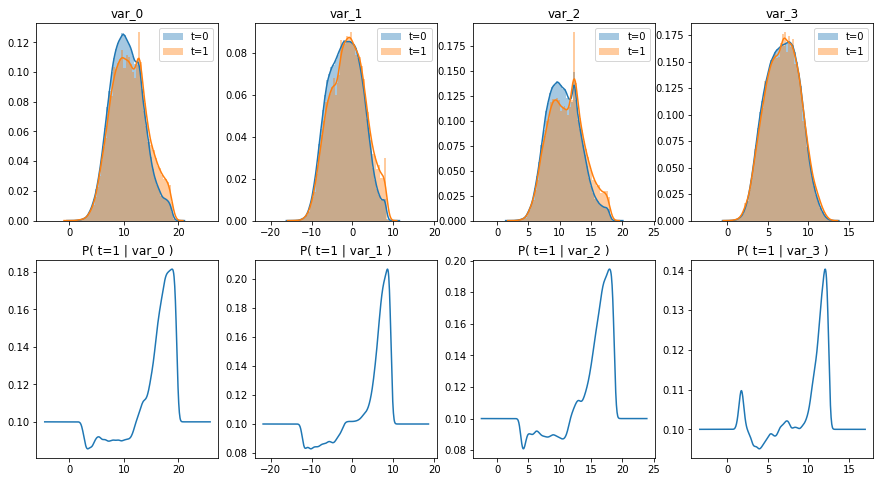

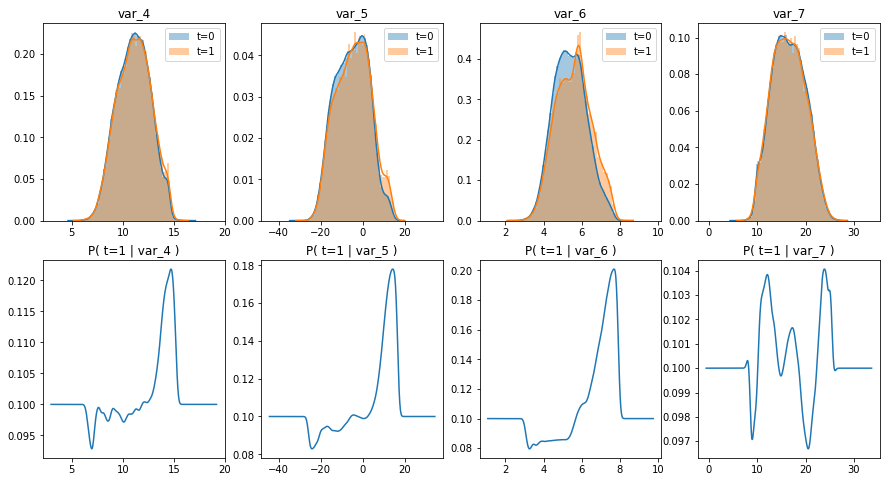

Showing vars 8 to 15 ...


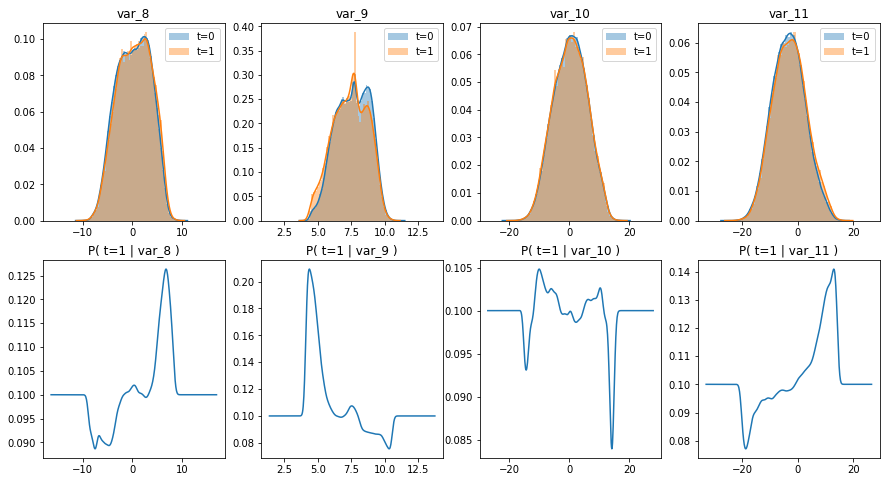

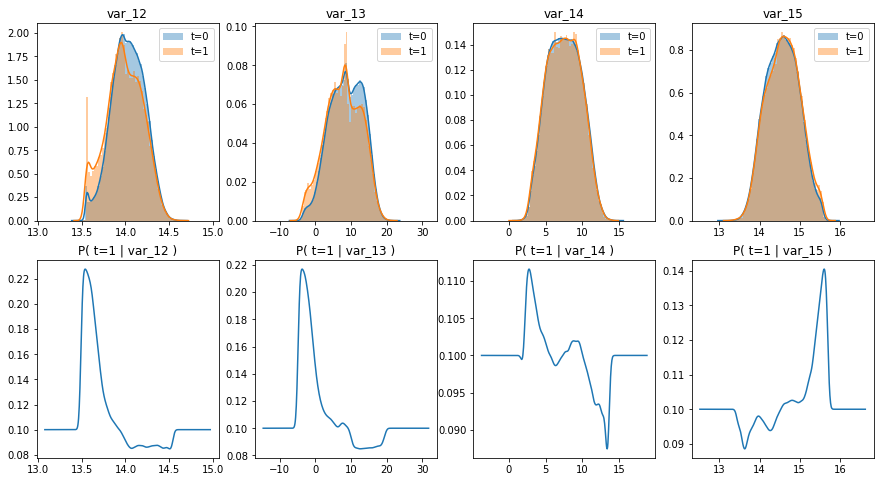

Showing vars 16 to 23 ...


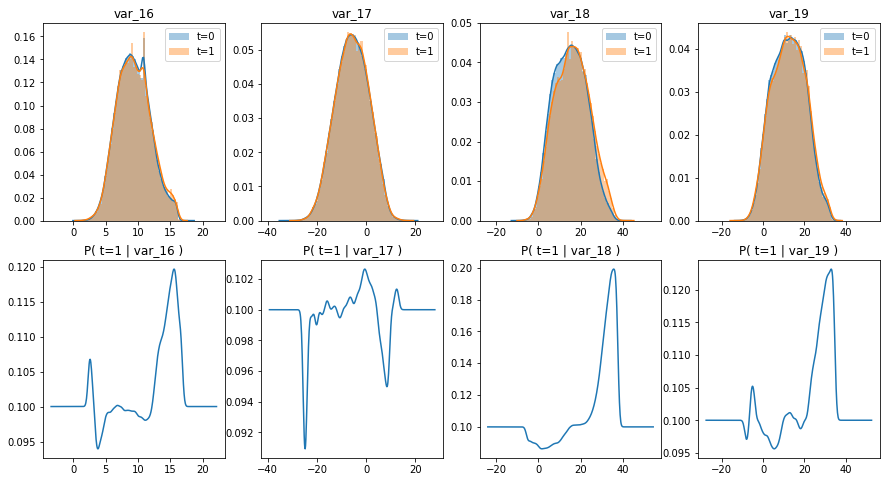

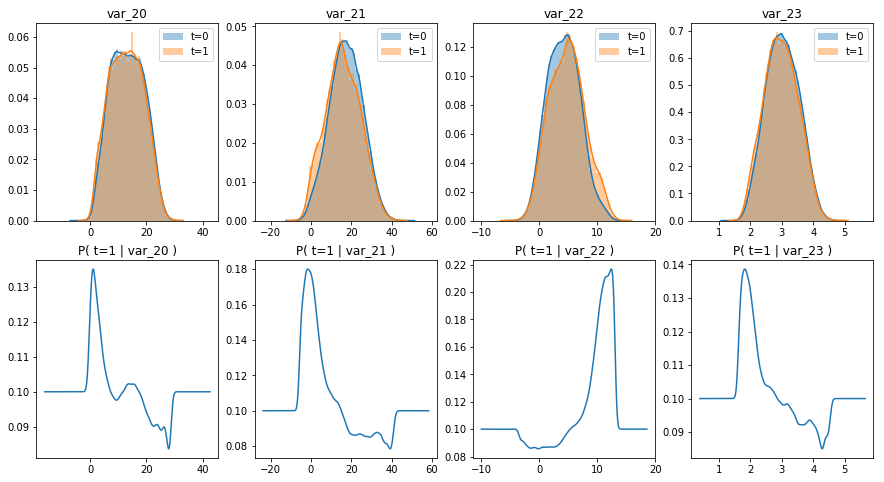

Showing vars 24 to 31 ...


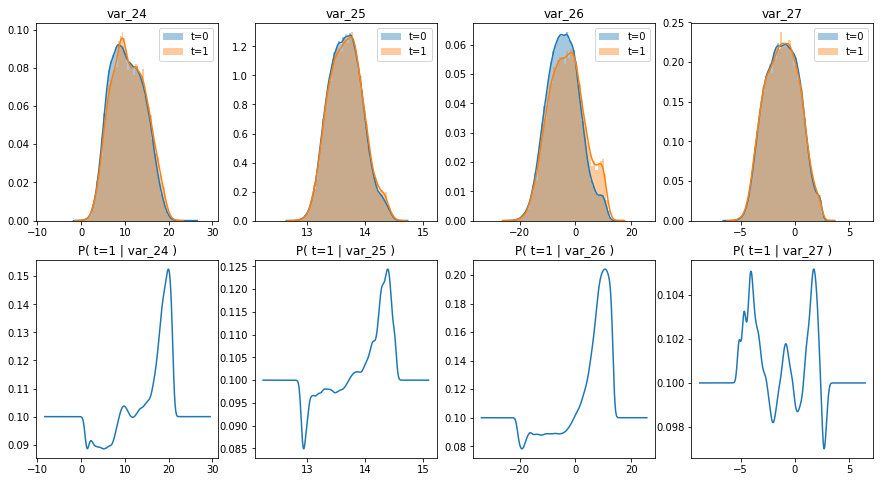

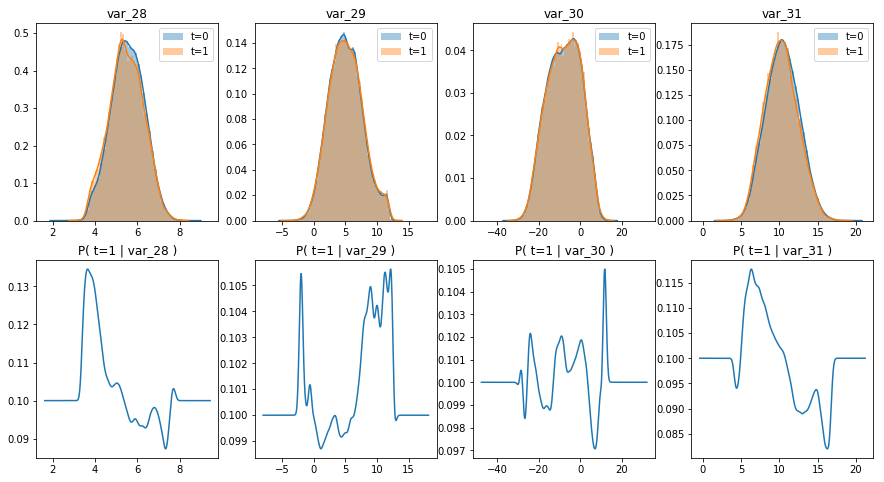

Showing vars 32 to 39 ...


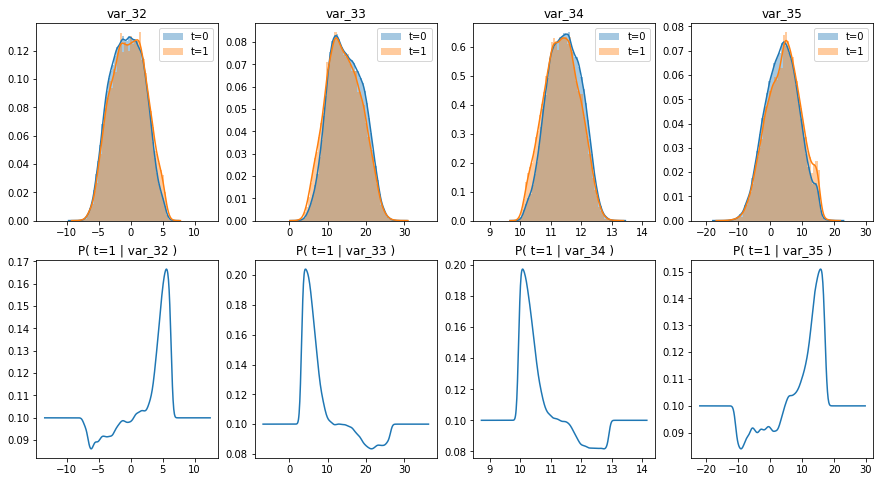

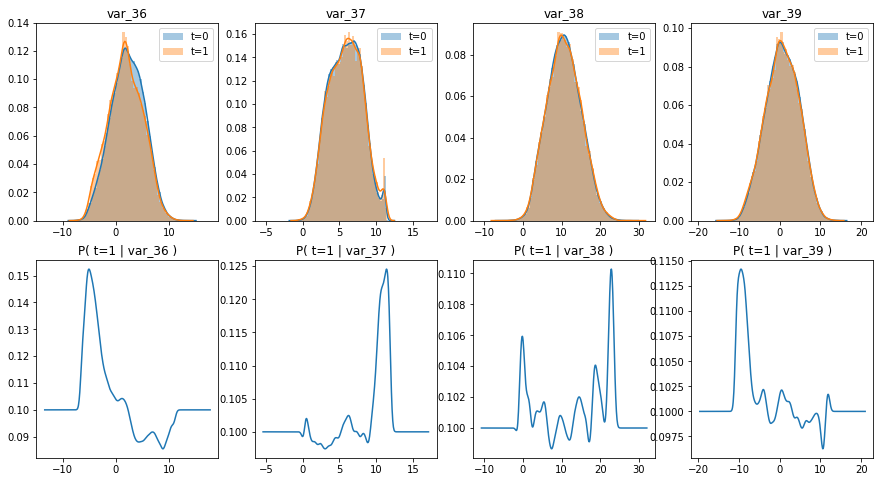

Showing vars 40 to 47 ...


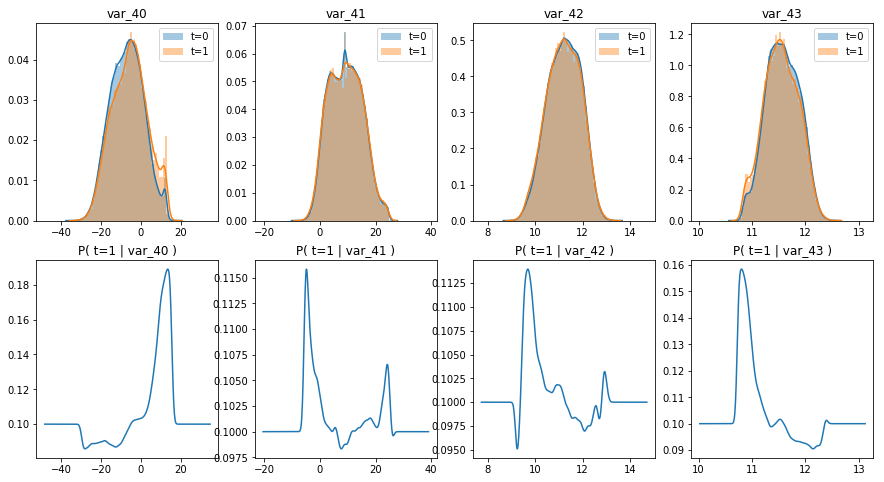

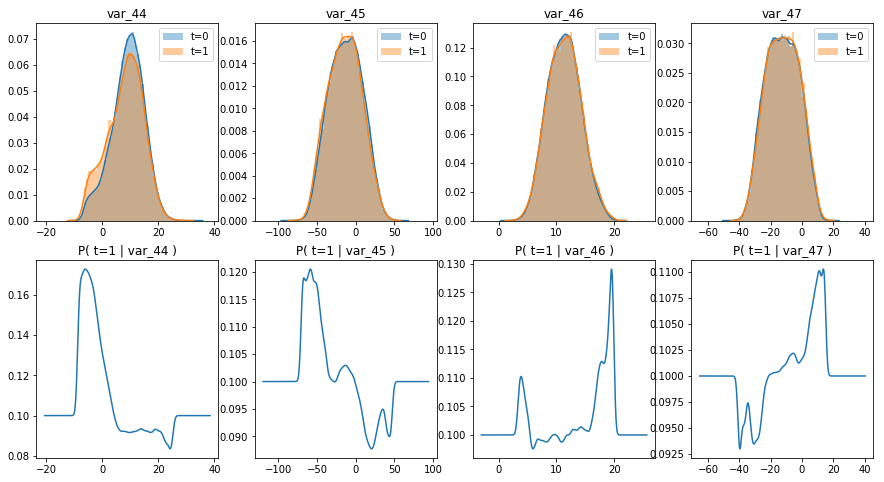

Showing vars 48 to 55 ...


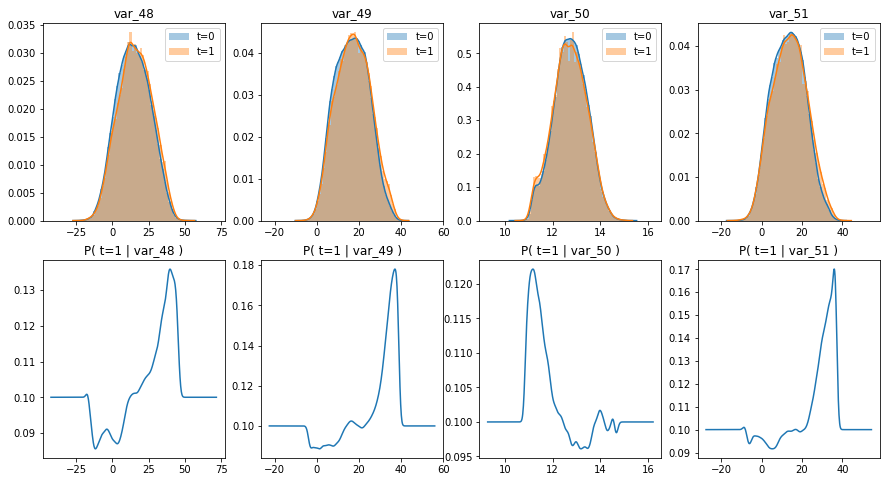

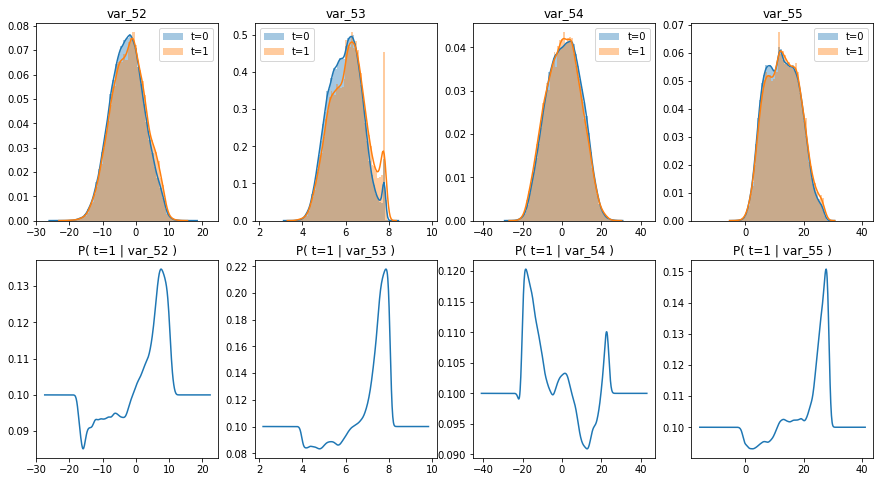

Showing vars 56 to 63 ...


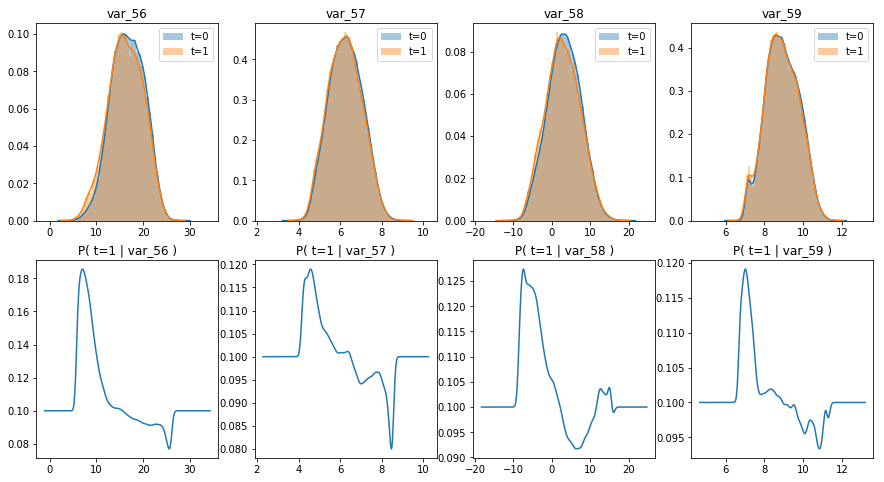

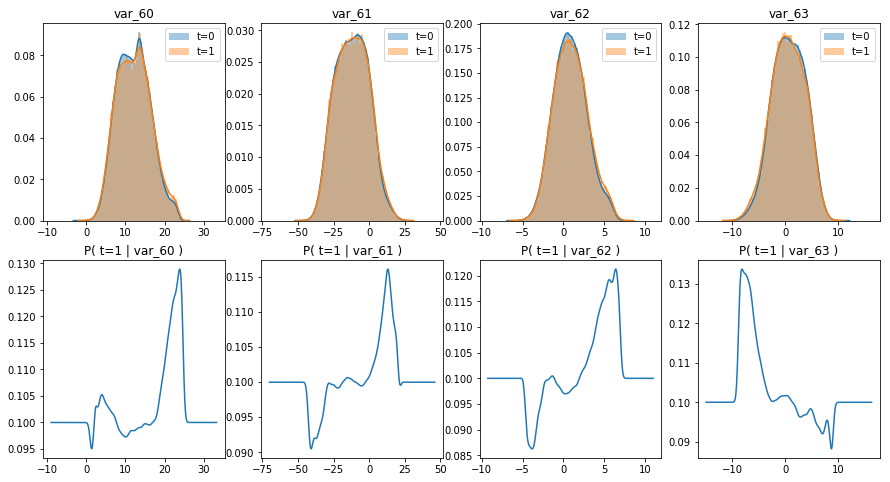

Showing vars 64 to 71 ...


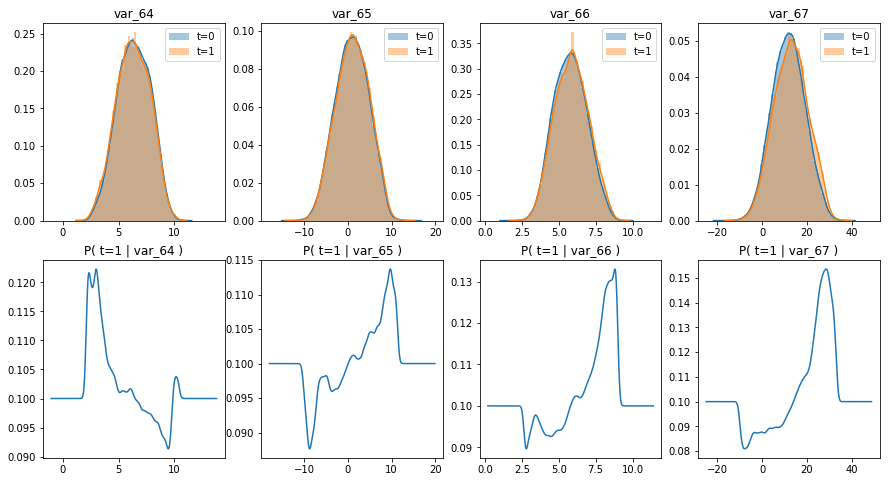

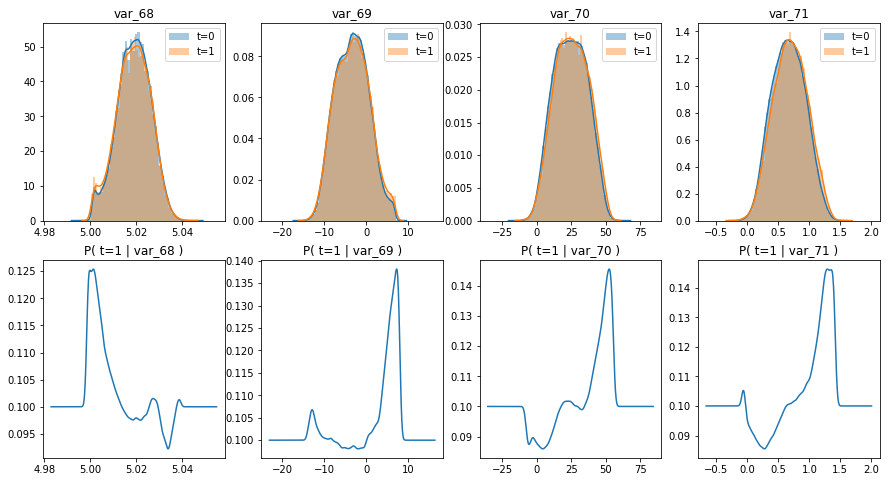

Showing vars 72 to 79 ...


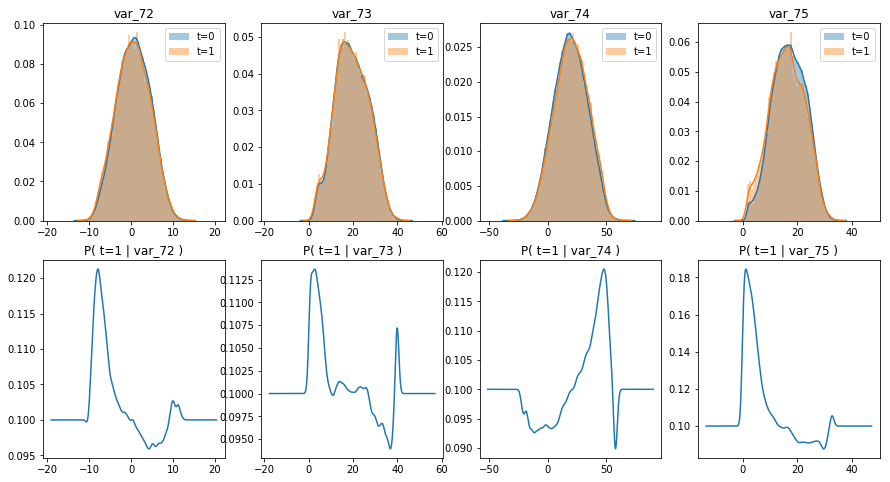

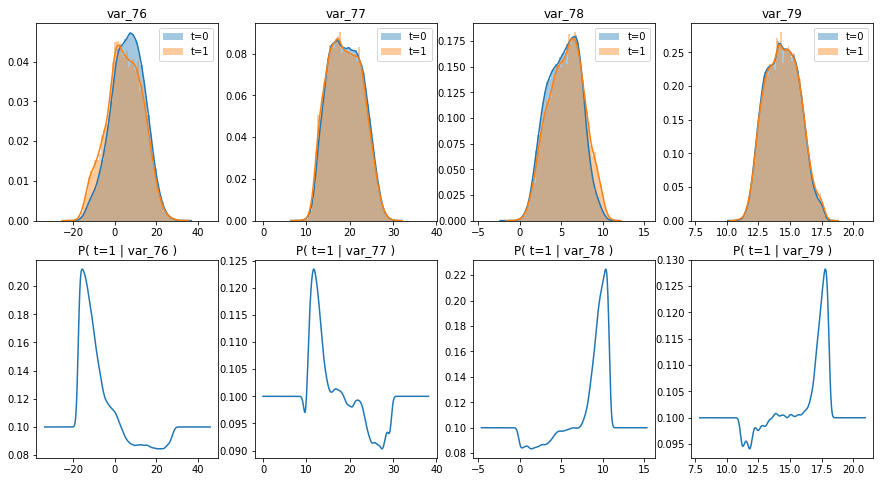

Showing vars 80 to 87 ...


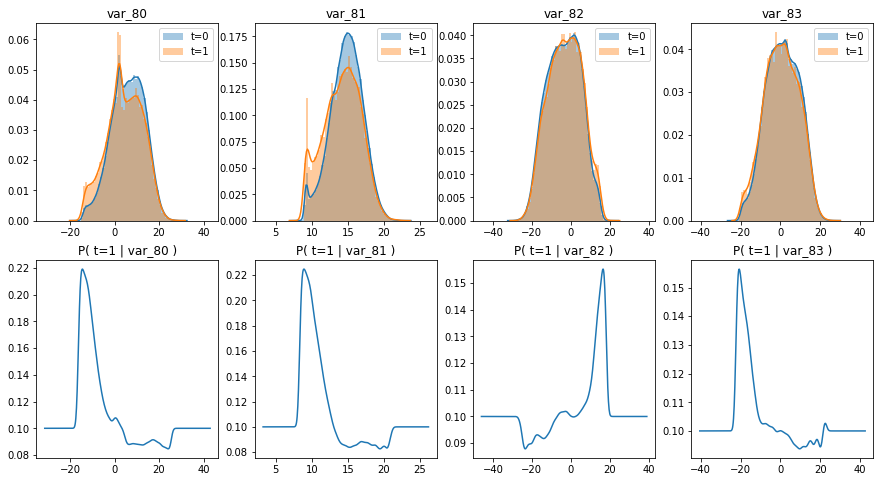

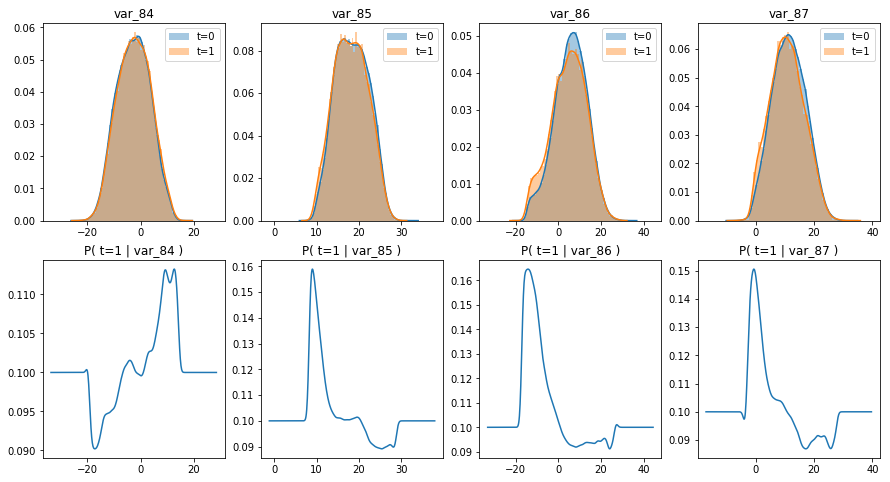

Showing vars 88 to 95 ...


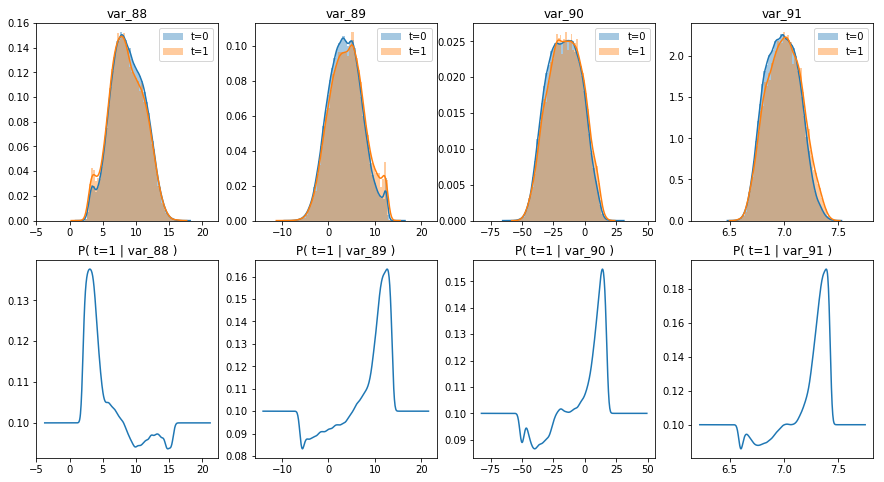

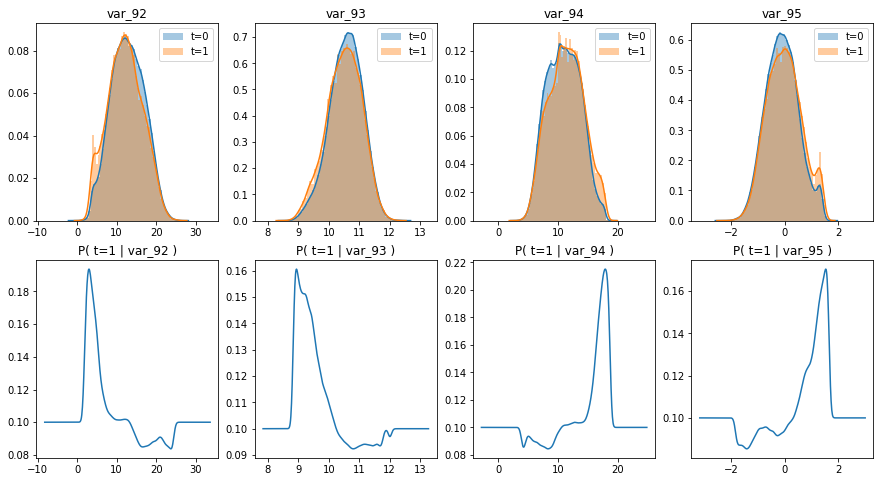

Showing vars 96 to 103 ...


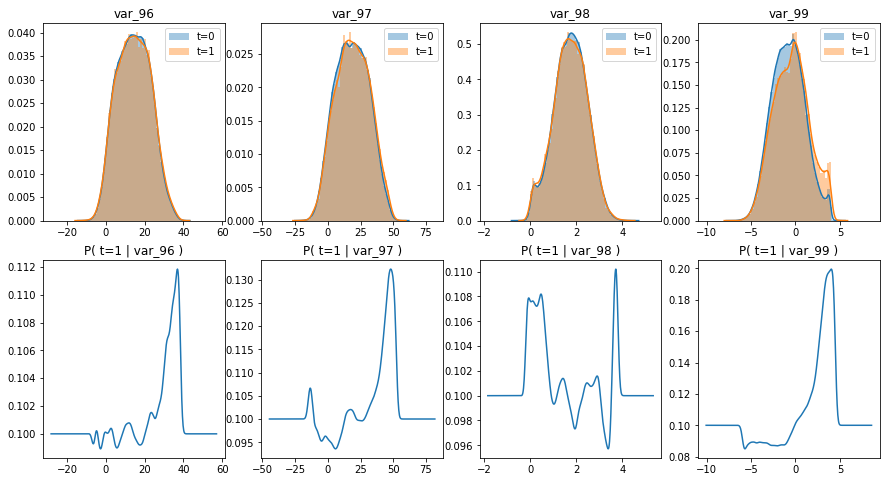

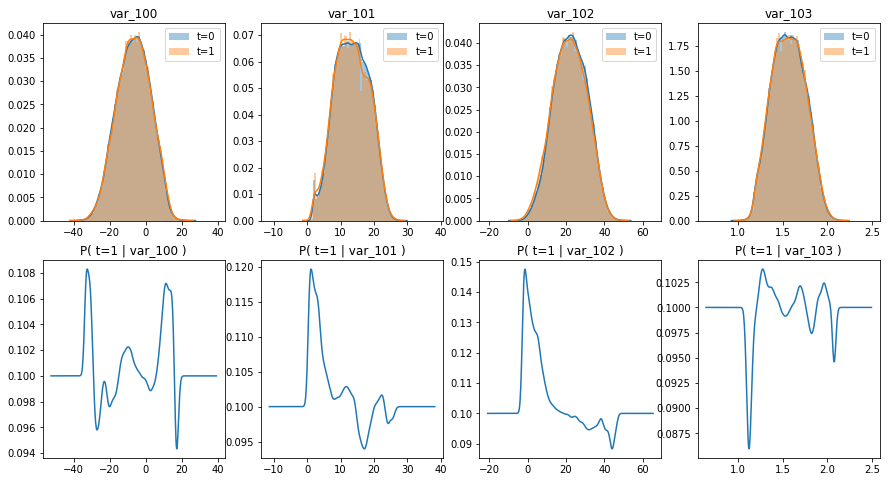

Showing vars 104 to 111 ...


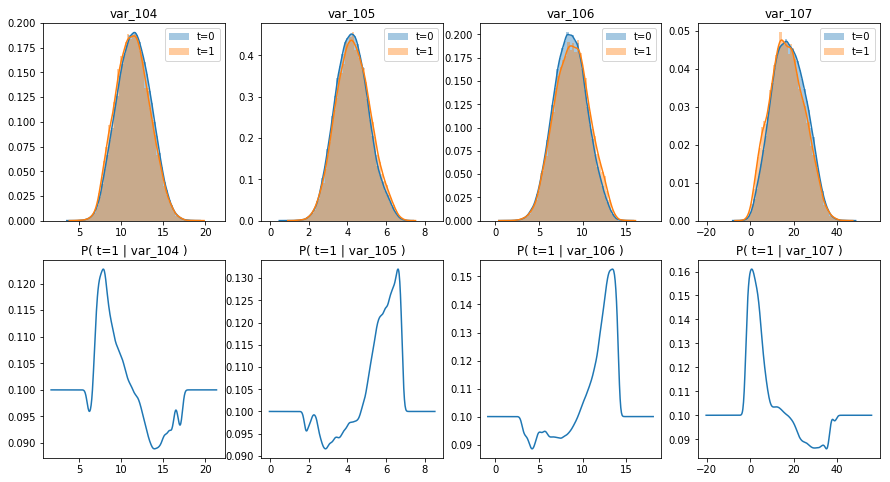

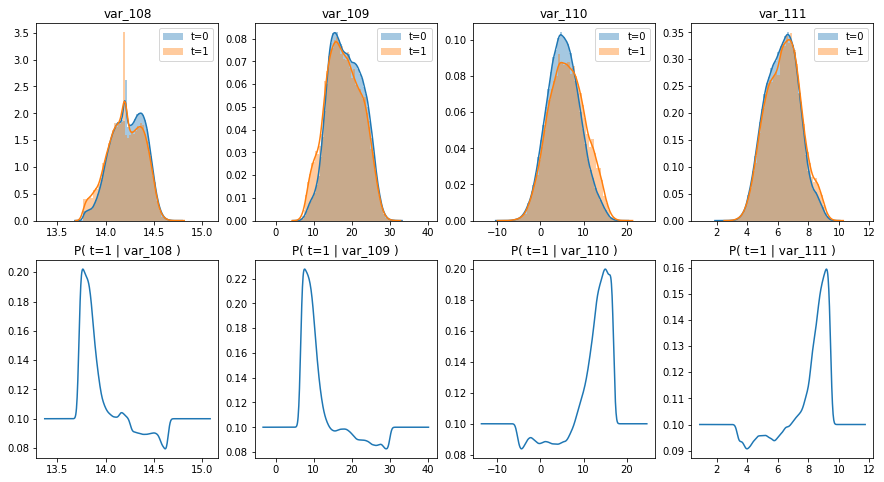

Showing vars 112 to 119 ...


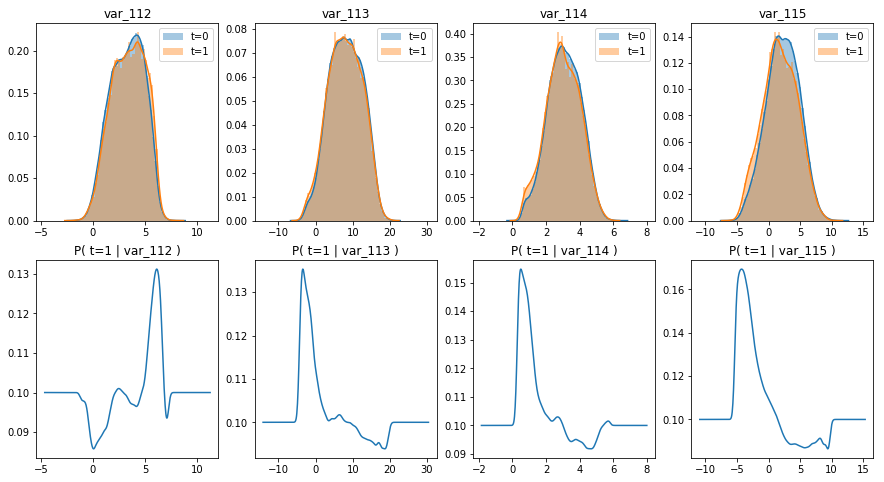

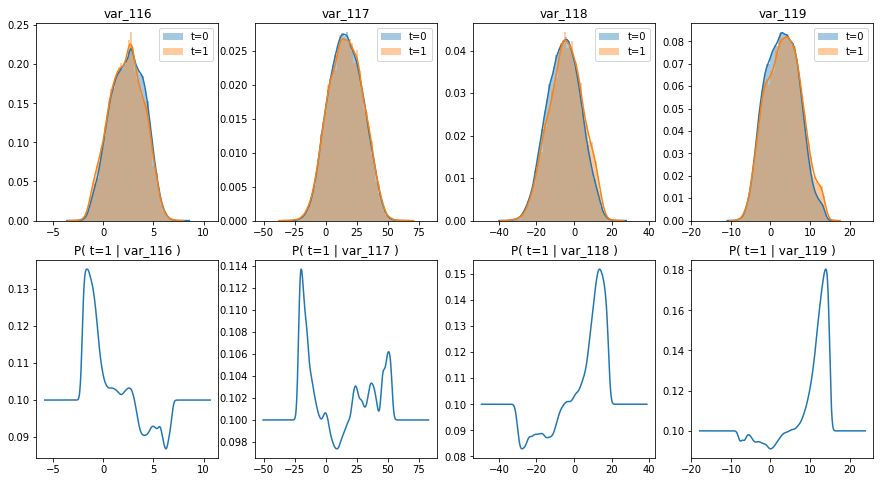

Showing vars 120 to 127 ...


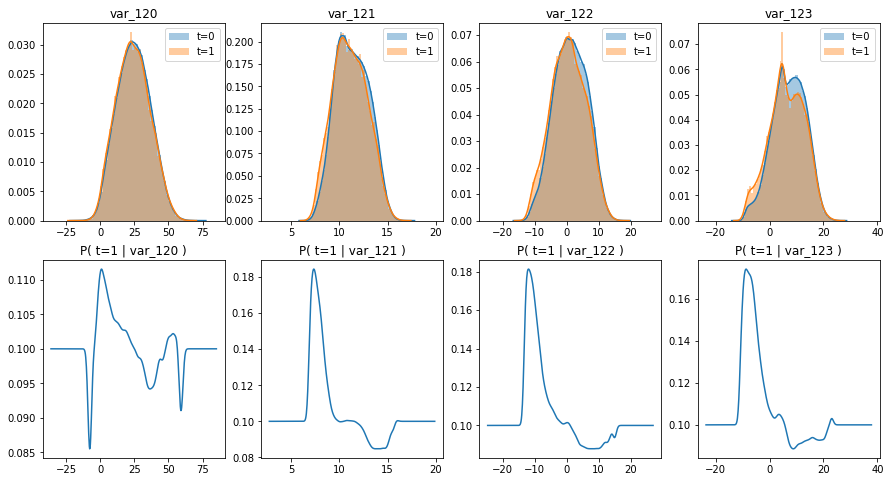

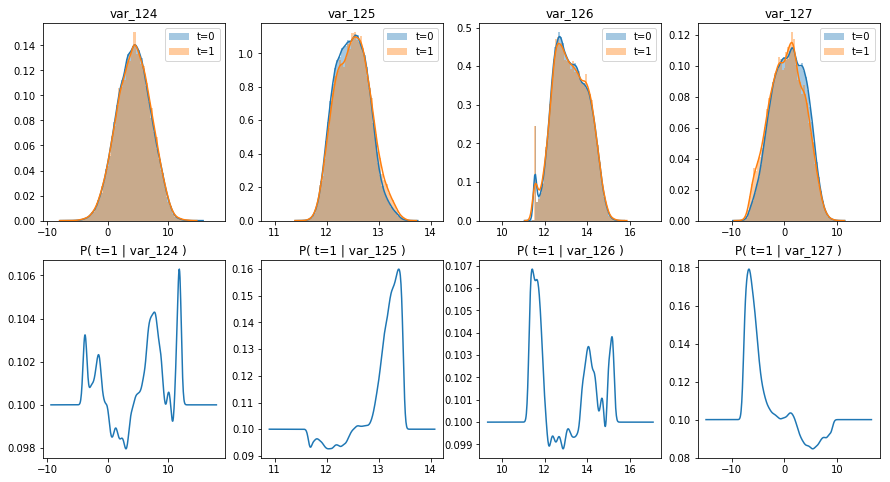

Showing vars 128 to 135 ...


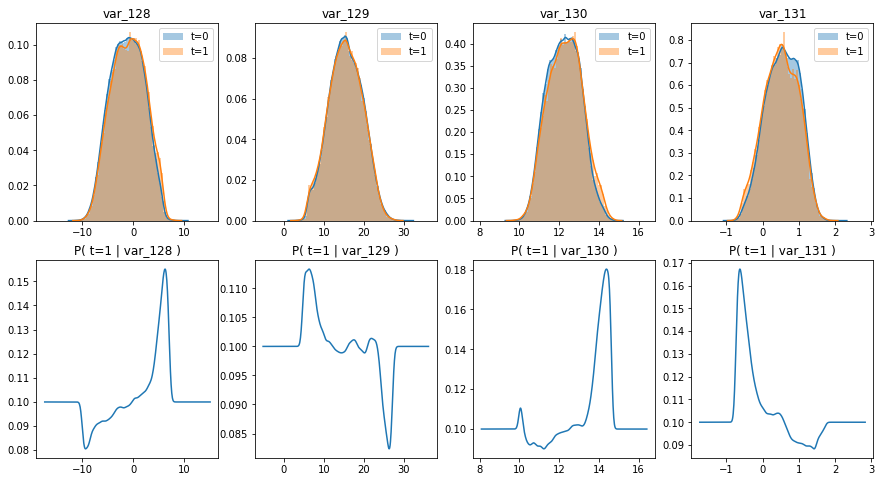

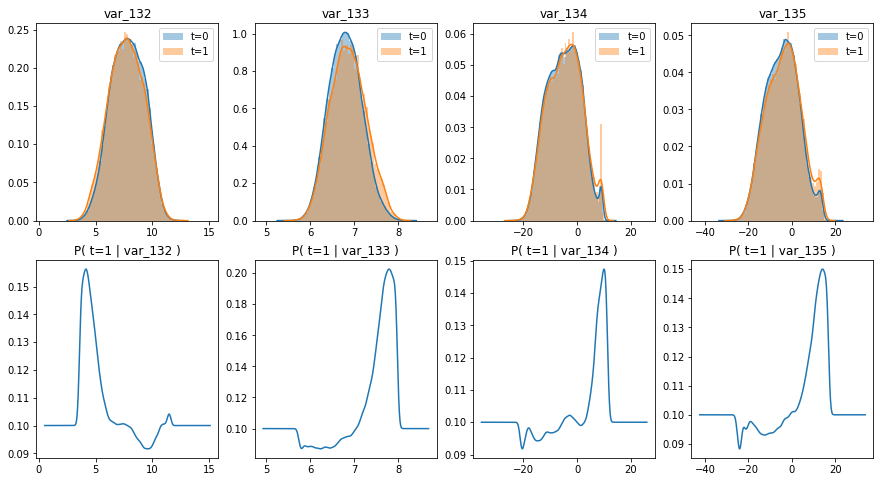

Showing vars 136 to 143 ...


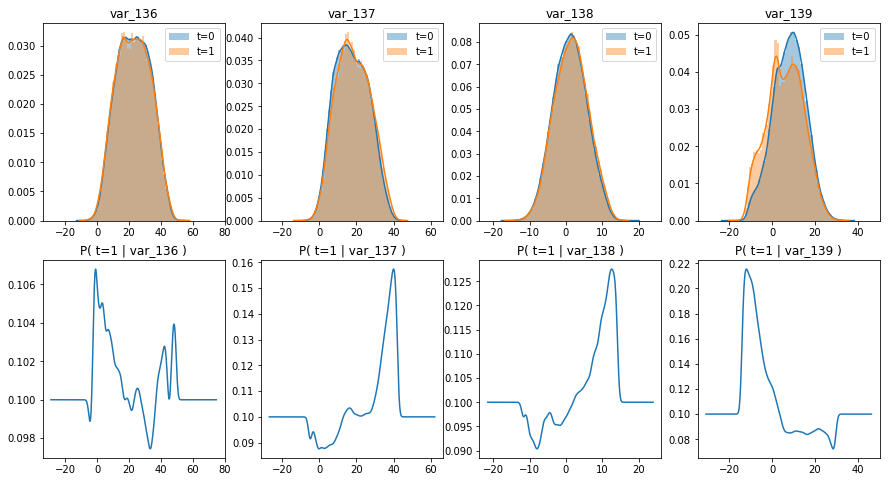

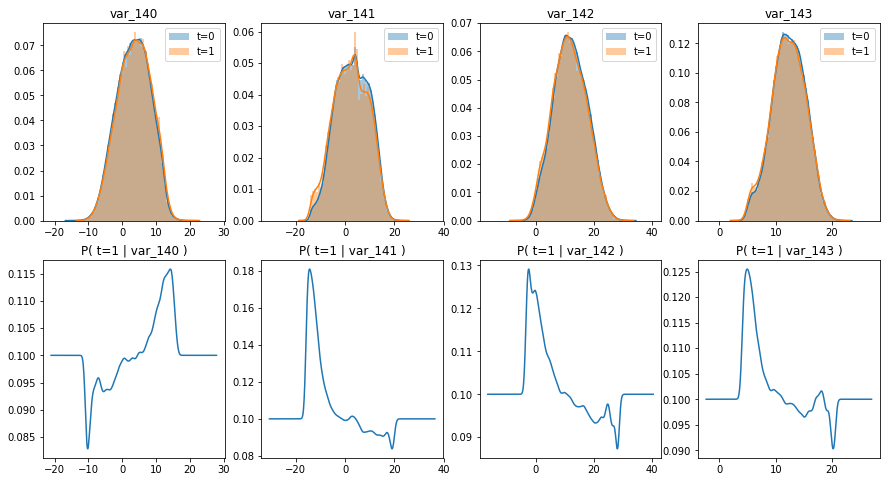

Showing vars 144 to 151 ...


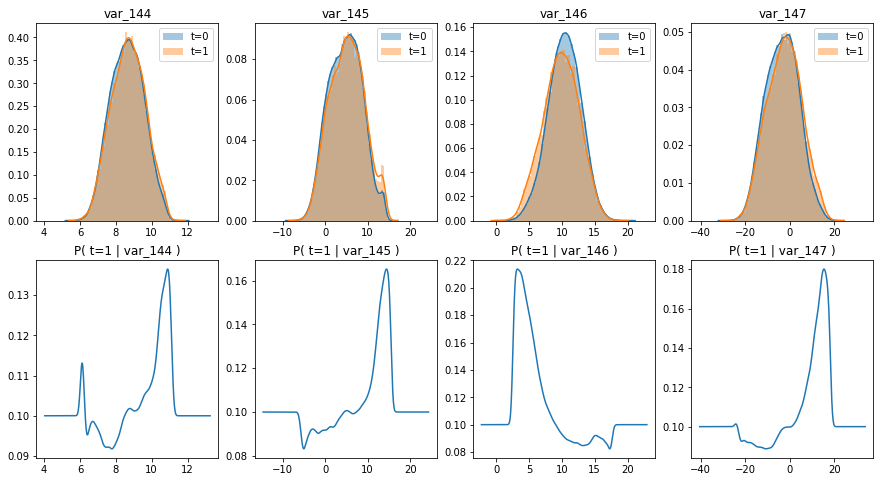

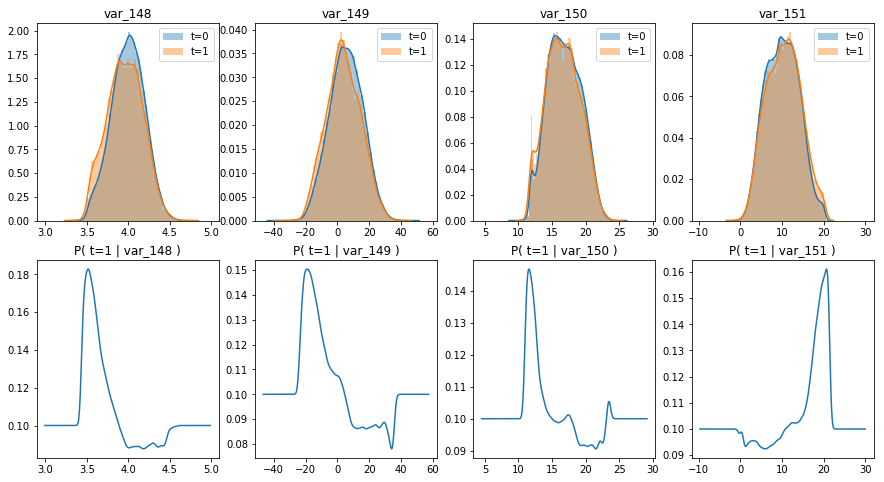

Showing vars 152 to 159 ...


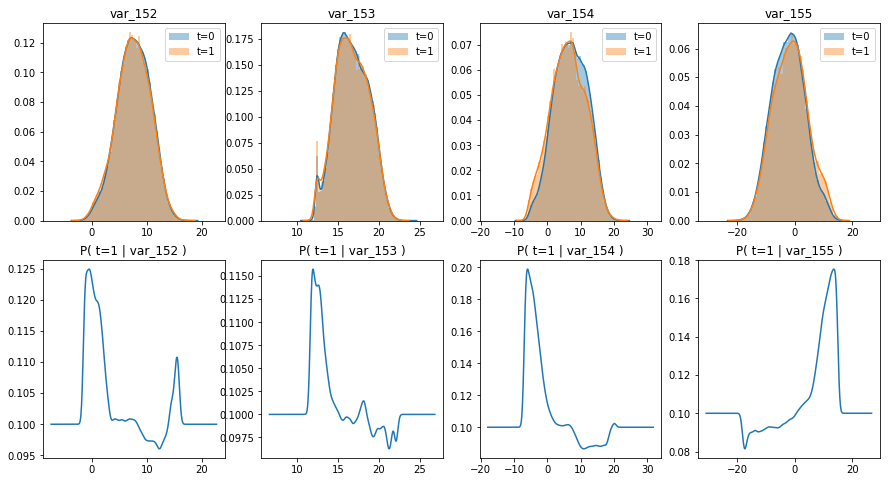

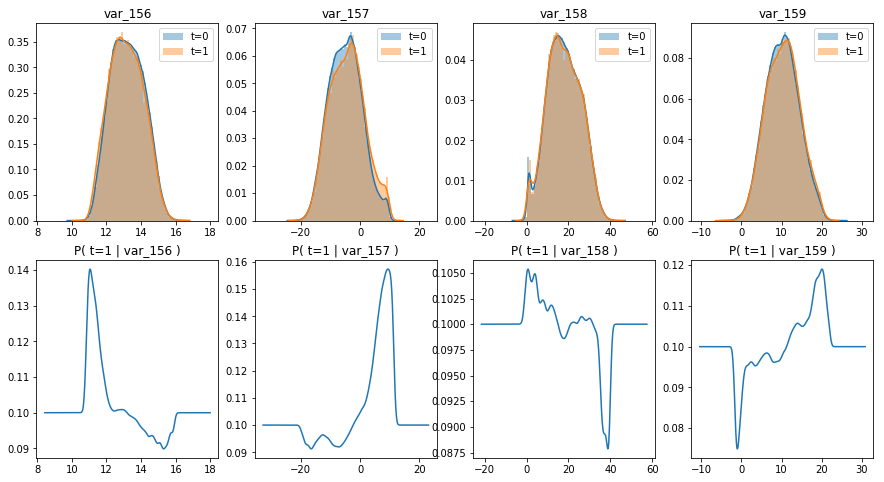

Showing vars 160 to 167 ...


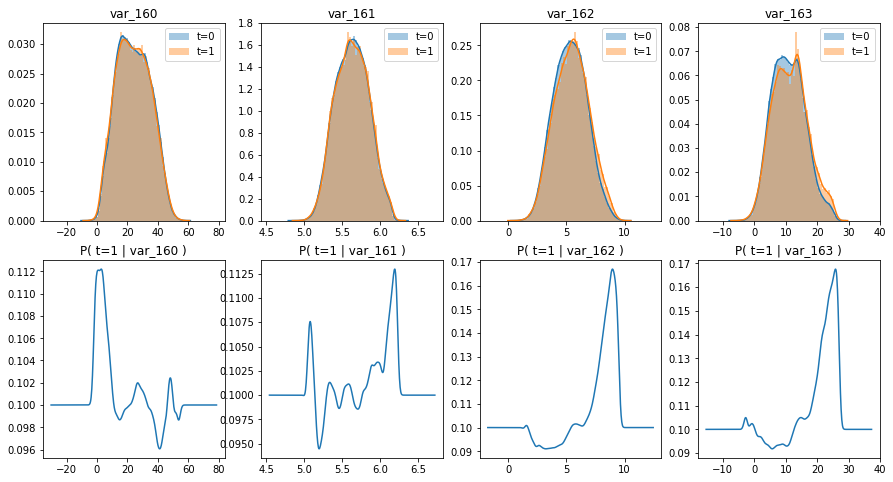

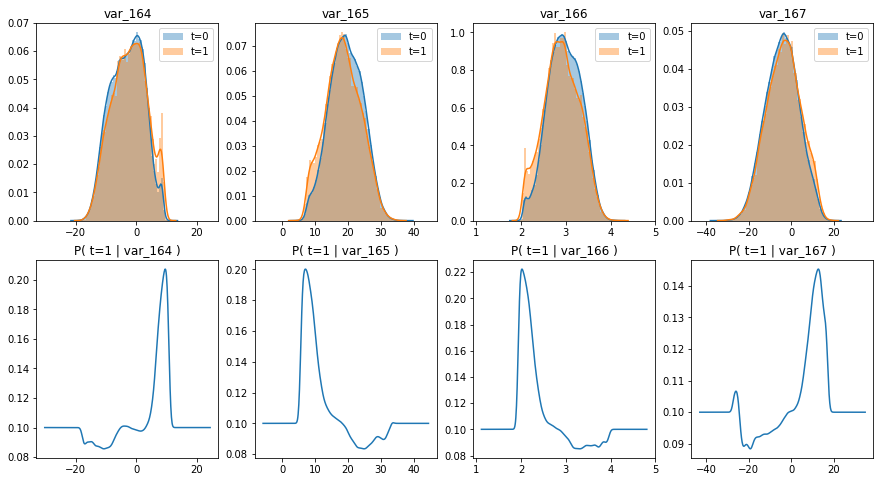

Showing vars 168 to 175 ...


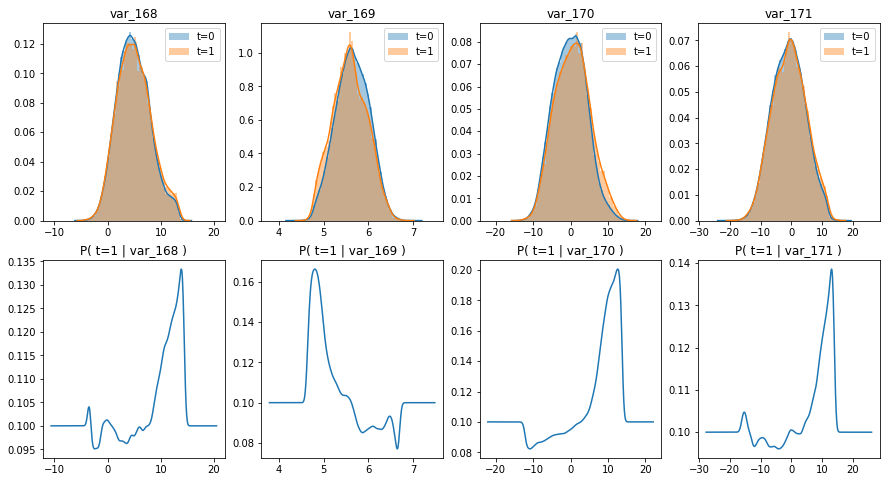

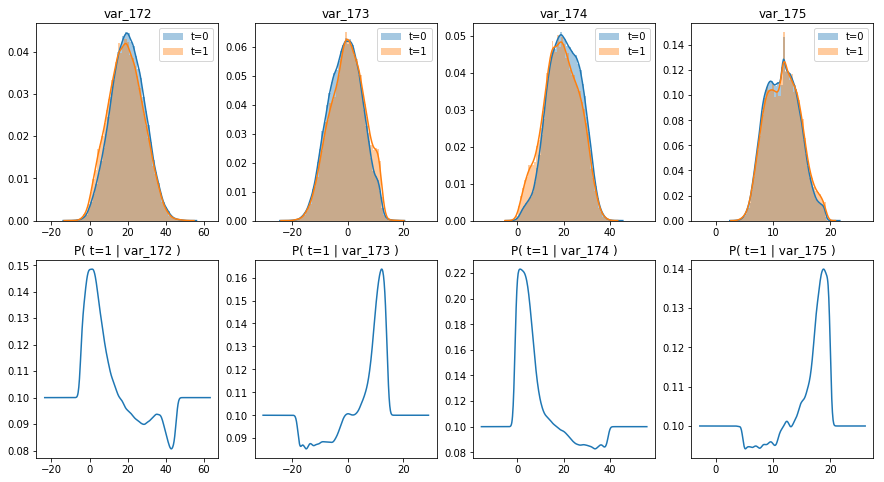

Showing vars 176 to 183 ...


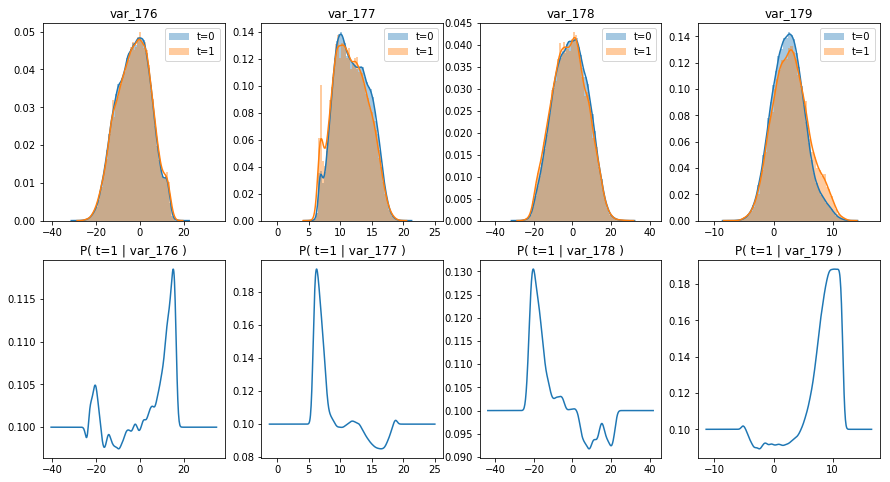

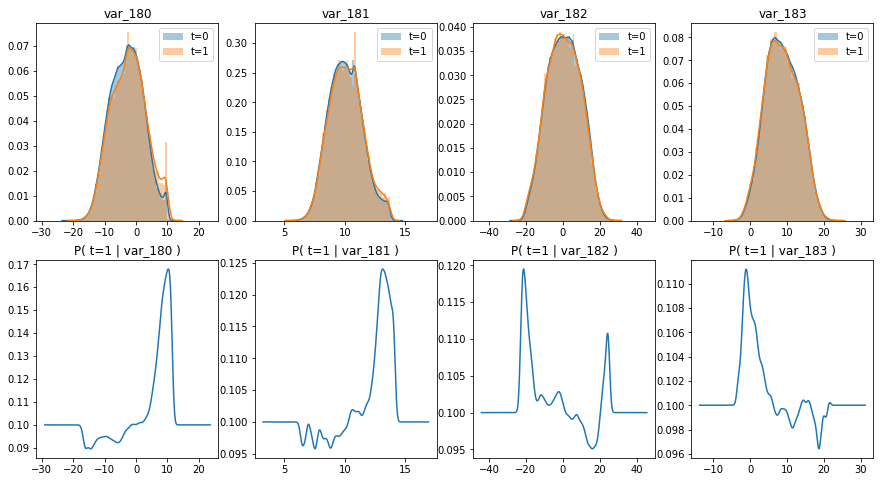

Showing vars 184 to 191 ...


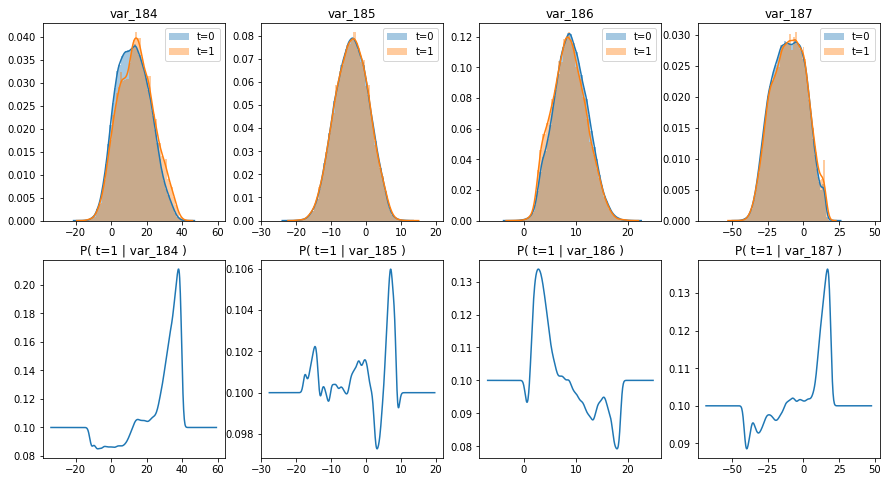

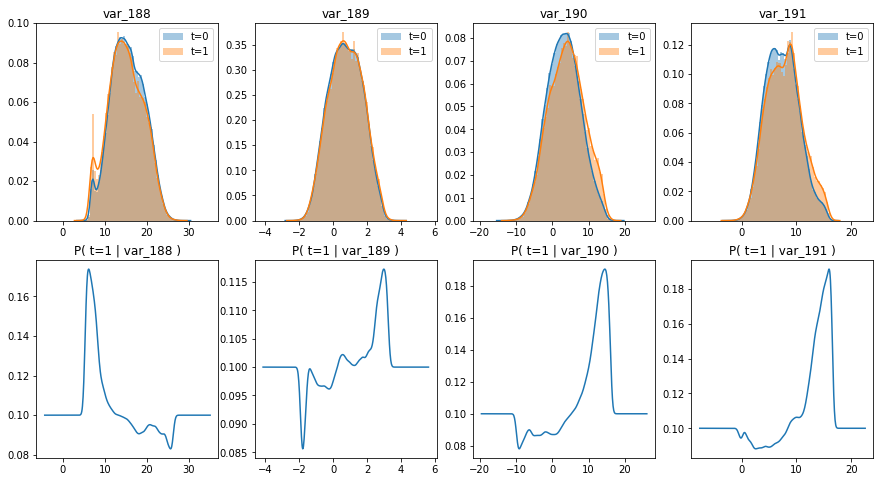

Showing vars 192 to 199 ...


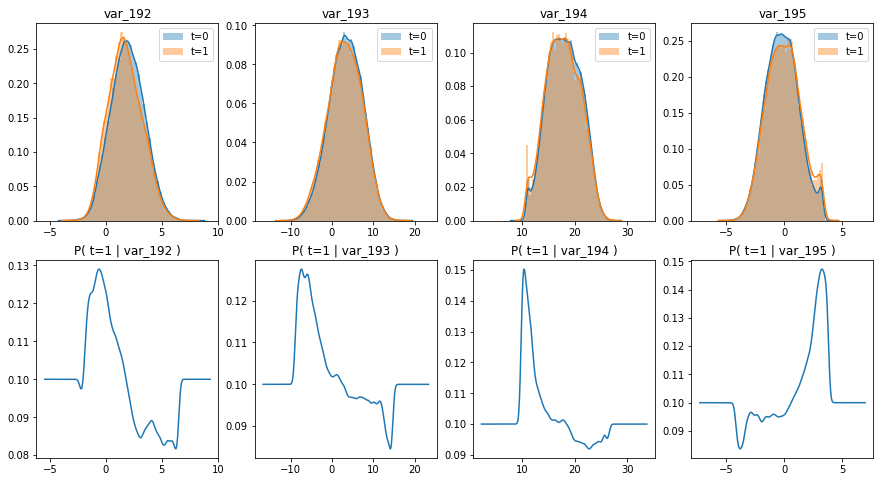

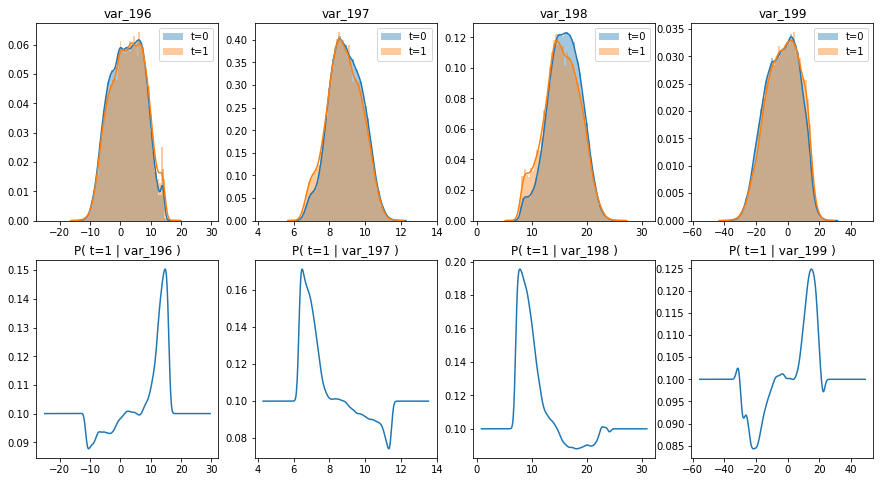

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# DRAW PLOTS, YES OR NO
Picture = True
# DATA HAS Z-SCORE RANGE OF -4.5 TO 4.5
rmin=-5; rmax=5; 
# CALCULATE PROBABILITIES FOR 501 BINS
res=501
# STORE PROBABILITIES IN PR
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in range(50):
    if Picture: plt.figure(figsize=(15,8))
    for v in range(4):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):  # [-5.  , -4.98, -4.96,..., 4.96, 4.98, 5]
            n_var = v+4*j  # 第n个var
            pr[n_var,ct] = getp(n_var,
                                m[n_var]+i*s[n_var]  # i in [-5, 5]
                               )
            xr[n_var,ct] = m[n_var]+i*s[n_var]
            xr2[n_var,ct] = i
            ct += 1
        if Picture:
            # SMOOTH FUNCTION FOR PRETTIER DISPLAY
            # BUT USE UNSMOOTHED FUNCTION FOR PREDICTION
            pr2[v+4*j,:] = smooth(pr[n_var,:],res//10)
            # DISPLAY PROBABILITY FUNCTION
            plt.subplot(2, 4, ct2%4+5)
            plt.plot(xr[n_var,:],pr2[n_var,:],'-')
            plt.title('P( t=1 | var_'+str(v+4*j)+' )')
            xx = plt.xlim()
            # DISPLAY TARGET DENSITIES
            plt.subplot(2, 4, ct2%4+1)            
            sns.distplot(train0['var_'+str(v+4*j)], label = 't=0')
            sns.distplot(train1['var_'+str(v+4*j)], label = 't=1')
            plt.title('var_'+str(v+4*j))
            plt.legend()
            plt.xlim(xx)
            plt.xlabel('')
        if (ct2%8==0): print('Showing vars',ct2,'to',ct2+7,'...')
        ct2 += 1
    if Picture: plt.show()

# Target Probability Function
Above, the target probability function was calculated for each variable with resolution equal to `standard deviation / 50` from -5 to 5. 

For example, we know the `Probability ( target=1 | var=x )` for `z-score = -5.00, -4.98, ..., -0.02, 0, 0.02, ..., 4.98, 5.00` where `z-score = (x - var_mean) / (var_standard_deviation)`. The python function below accesses these pre-calculated values from their numpy array.

In [13]:
(rmax-rmin)/(res-1)

0.02

In [7]:
def getp2(i,x):
    """
    :i: n_var
    :x: 某个样本的var_n的取值
    """
    z = (x-m[i])/s[i]
    ss = (rmax-rmin)/(res-1)
    if res%2==0: idx = min( (res+1)//2 + z//ss, res-1)
    else: idx = min( (res+1)//2 + (z-ss/2)//ss, res-1)  # res=501, idx=min(251+(z-0.01)//0.02, 500)
    idx = max(idx,0)
    return pr[i,int(idx)]

# Validation
We will ignore the training data's target and make our own prediction for each training observation. 

Then using our predictions and the true value, we will calculate validation AUC. (There is a leak in this validation method but none-the-less it gives an approximation of CV score. 

If you wish to tune this model, you should use a proper validation set. Current actual 5-fold CV is 0.8995)

In [8]:
from sklearn.metrics import roc_auc_score
print('Calculating 200000 predictions and displaying a few examples...')
pred = [0]*200000; ct = 0
for r in train.index:
    p = 0.1
    for i in range(200):
        # getp2(i,train.iloc[r,2+i]): 在对应样本的var_i取值时，label=1的概率
        # 为什么是相乘？相加取平均不更合理么？
        # 10*getp2(i,train.iloc[r,2+i])的理论上的取值返回时[0, 10]
        p *= 10*getp2(i,train.iloc[r,2+i])  
    if ct%25000==0: print('train',r,'has target =',train.iloc[r,1],'and prediction =',p)
    pred[ct]=p; ct += 1
print('###############')
print('Validation AUC =',roc_auc_score(train['target'], pred))

Calculating 200000 predictions and displaying a few examples...
train 0 has target = 0 and prediction = 0.020849097518485876
train 25000 has target = 0 and prediction = 0.047234280974034905
train 50000 has target = 0 and prediction = 0.10883774386764035
train 75000 has target = 0 and prediction = 0.6218646945701704
train 100000 has target = 0 and prediction = 0.12978893156190568
train 125000 has target = 0 and prediction = 0.019172676892370028
train 150000 has target = 0 and prediction = 0.0620863147443581
train 175000 has target = 0 and prediction = 0.0716070547437789
###############
Validation AUC = 0.9055702103328558


In [22]:
from sklearn.metrics import roc_auc_score
print('Calculating 200000 predictions and displaying a few examples...')
pred = [0]*200000; ct = 0
for r in train.index:
    p = 0.0
    for i in range(200):
        # getp2(i,train.iloc[r,2+i]): 在对应样本的var_i取值时，label=1的概率
        # 为什么是相乘？相加取平均不更合理么？
        # 10*getp2(i,train.iloc[r,2+i])的理论上的取值返回时[0, 10]
        x = getp2(i,train.iloc[r,2+i])
        p += 10*x/(9*x+1) 
    p /= 200
    if ct%25000==0: print('train',r,'has target =',train.iloc[r,1],'and prediction =',p)
    pred[ct]=p; ct += 1
print('###############')
print('Validation AUC =',roc_auc_score(train['target'], pred))

Calculating 200000 predictions and displaying a few examples...
train 0 has target = 0 and prediction = 0.0995586982486158
train 25000 has target = 0 and prediction = 0.10006918458839788
train 50000 has target = 0 and prediction = 0.10060511393882499
train 75000 has target = 0 and prediction = 0.1015635990908721


KeyboardInterrupt: 

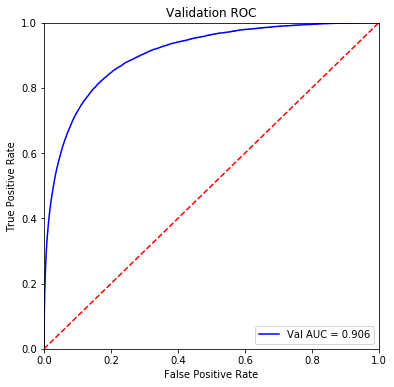

In [9]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(train['target'], pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Predict Test and Submit
Naive Bayes is a simple model. Given observation with `var_0 = 15`, `var_1 = 5`, `var_2 = 10`, etc. We compute the probability that `target=1` by calculating `P(t=1) * P(t=1 | var_0=15)/P(t=1) * P(t=1 | var_1=5)/P(t=1) * P(t=1 | var_2=10)/P(t=1) * ...` where `P(t=1)=0.1` and the other probabilities are computed above by counting occurences in the training data. So each observation has 200 variables and we simply multiply together the 200 target probabilities given by each variable. (In typical Naive Bayes, you use Bayes formula, reverse the probabilities, and find `P(var_0=15 | t=1)`. This is modified Naive Bayes and more intuitive.)

In [10]:
test = pd.read_csv('../input/test.csv')
print('Calculating 200000 predictions and displaying a few examples...')
pred = [0]*200000; ct = 0
for r in test.index:
    p = 0.1
    for i in range(200):
        p *= 10*getp2(i,test.iloc[r,1+i])
    if ct%25000==0: print('test',r,'has prediction =',p)
    pred[ct]=p
    ct += 1
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = pred
sub.to_csv('submission.csv',index=False)
print('###############')
print('Finished. Wrote predictions to submission.csv')

Calculating 200000 predictions and displaying a few examples...
test 0 has prediction = 0.2082829737241022
test 25000 has prediction = 0.08746040244836348
test 50000 has prediction = 0.03525447935028704
test 75000 has prediction = 0.020404861938145294
test 100000 has prediction = 0.023421247991439808
test 125000 has prediction = 0.03731506699908677
test 150000 has prediction = 0.4077818139424838
test 175000 has prediction = 0.07305722168183842
###############
Finished. Wrote predictions to submission.csv


# Plot Predictions

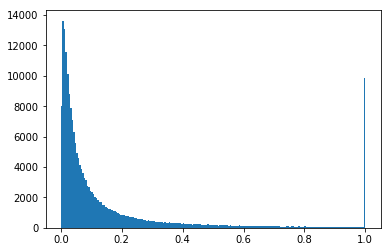

In [11]:
sub.loc[ sub['target']>1 , 'target'] = 1
b = plt.hist(sub['target'], bins=200)

# Conclusion
In conclusion we used modified Naive Bayes to predict Santander Customer transactions. 

Since we achieved an accurate score of 0.899 LB (which rivals other methods that capture interactions), this demonstrates that there is little or no interaction between the 200 variables. 

Additionally in this kernel we observed some fascinating EDA which provide insights about the variables. Can this method be improved? Perhaps by tuning this model better (adjust smoothing, resolution, etc) we can increase validation AUC and increase LB AUC but I don't think we can score over 0.902 with this method. There are other secrets hiding in the Santander data.
![image](http://playagricola.com/Kaggle/score32319.png)